In [10]:
from PIL import Image
import requests

from transformers import CLIPProcessor, CLIPModel
from transformers import AutoTokenizer, CLIPTextModelWithProjection
from transformers import AutoProcessor, CLIPVisionModelWithProjection
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

from sklearn.manifold import TSNE
import scipy.stats as st 
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, confusion_matrix
from tqdm import tqdm
import numpy as np
import pickle
from sklearn.metrics.pairwise import pairwise_distances_argmin, pairwise_distances

import graph_structure as gs

In [2]:
image_pickle_file_path = "../data/embeds_images_imagenet32.pkl"
image_data = pickle.load(open(image_pickle_file_path, 'rb'))
text_pickle_file_path = "../data/embeds_texts_imagenet32.pkl"
text_data = pickle.load(open(text_pickle_file_path, 'rb'))

data = image_data | text_data
image_embeds = data["image_embeds"]
y_real = data["y_real"]
text_embeds = data["text_embeds"]
templates = data["templates"]
texts = data["texts"]
classes = data["classes"]


In [3]:
def class_rep(X, y):
    X_ = []
    y_ = []
    for c in set(list(y)):
        X_.append(np.mean (X[y==c], axis=0))
        y_.append(c)
    return np.array(X_), np.array(y_).reshape( (-1, 1))



In [5]:
X, y = class_rep(np.squeeze(image_embeds), np.squeeze(y_real))
k = 3
acc = []
jdist = []
for i in tqdm(range(len(templates))):
    Z = text_embeds[i::len(templates),:]
    cos_sim = pairwise_distances_argmin(np.squeeze(image_embeds), Z, metric="cosine")
    acc.append(accuracy_score(y_real, cos_sim))
    #dg = mean_neighborhoood_distance(X, Z, 5)
    dg = gs.mean_neighborhood_similarity_from_points(X, Z, k)
    jdist.append(dg)

print(acc)
print(jdist)
print(st.pearsonr(jdist, acc))
print(st.spearmanr(jdist, acc))

100%|██████████| 18/18 [00:10<00:00,  1.65it/s]

[0.59322, 0.59326, 0.56294, 0.59706, 0.56778, 0.60094, 0.60216, 0.58492, 0.56512, 0.58124, 0.56764, 0.54732, 0.5812, 0.5678, 0.57792, 0.58046, 0.58962, 0.5611]
[0.2312999999999979, 0.2393999999999977, 0.23759999999999784, 0.24569999999999775, 0.2434999999999975, 0.24009999999999765, 0.23629999999999757, 0.23909999999999773, 0.22889999999999794, 0.21339999999999815, 0.22279999999999814, 0.2177999999999983, 0.22849999999999812, 0.22349999999999817, 0.22599999999999806, 0.2182999999999983, 0.23799999999999782, 0.2153999999999982]
PearsonRResult(statistic=0.5372028256496736, pvalue=0.02150579593071253)
SignificanceResult(statistic=0.5500515995872033, pvalue=0.018027593361137465)


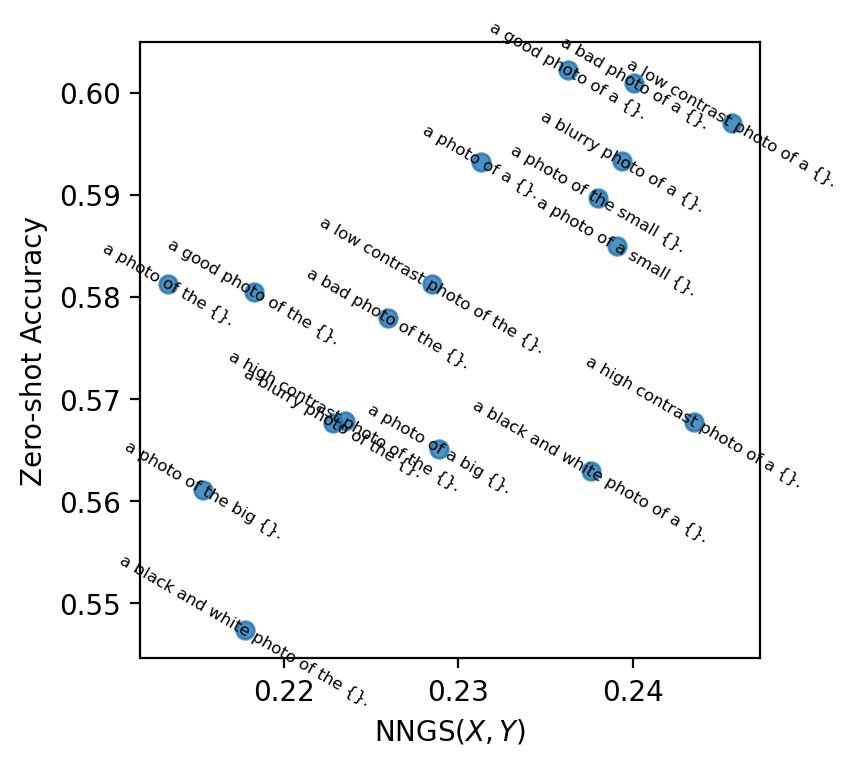

In [6]:
plt.figure(figsize=(4,4))
plt.scatter(jdist, acc, s=40, alpha=0.8)
for i in range(len(templates)):
    plt.text(jdist[i], acc[i], templates[i], fontsize=6, ha='center', va='center', rotation=-30)
    #plt.text(jdist[i], acc[i]-0.01, ks[i], fontsize=8, ha='center', va='top')
plt.xlabel('$\\text{NNGS}(X,Y)$')
plt.ylabel('Zero-shot Accuracy')
plt.savefig('zeroshot_sg_imagenet.pdf', bbox_inches='tight')
plt.show()

# With added templates

In [11]:
# templates_ = [
#     'No, Luke. I AM your {}.',
#     'Not a {}.',
#     'The sound of a {}.',
#     'Feel the power of a {}.',
#     'Born to be {}.',
#     'Hasta la vista, {}!',
#     'I am feeling supersonic, give me {} and tonic.',
#     'LOL {} is SO random!',
#     'Perhaps {} could help us save Robin from The Joker.',
#     'The wheels on the {} go round and round.',
#     'We all live in a yellow {}',
#     '{}.',
#     'I like {}',
#     'I cant find the {} here.',
#     'I can find the {} here.',
#     'Most {} are good-looking.',
#     'You are a {}, Harry!',
#     'AND MY {}!',
#     'We must take the {} to Mordor!',
# ]

templates_movies = [
    'Luke. I am your {}.',
    'The sound of a {}.',
    'Feel the power of a {}.',
    'Born to be {}.',
    'I am feeling supersonic, give me {} and tonic.',
    'Stop trying to make {} happen!',
    'Perhaps {} could help us save Robin from The Joker.',
    'The wheels on the {} go round and round.',
    'We all live in a yellow {}',
    'I can find the {} here.',
    '{}, we have a problem.',
    'You cannot handle the {}.',
    'I am the {} of the world.',
    'There is no place like {}.',
    'You are a {}, Harry!',
    'AND MY {}!',
    'We must take the {} to Mordor!',
]

# templates_ = [
#     'This is a {}.',
#     'This is not a {}.'
    
# ]

templates_neg = ['not ' + s for s in templates]

# templates_neg = [
#     'Luke. I am NOT your {}.',
#     'Not the sound of a {}.',
#     'Don\'t feel the power of a {}.',
#     'Not born to be {}.',
#     'I am not feeling supersonic, do not give me {} and tonic.',
#     'LOL {} is SO not random!',
#     'Perhaps {} could not help us save Robin from The Joker.',
#     'The wheels on the {} do not go round and round.',
#     'We do not live in a yellow {}',
#     'Not {}.',
#     'I do not like {}',
#     'I cannot find the {} here.',
#     'Most {} are bad-looking.',
#     'You are not a {}, Harry!',
#     'NOT MY {}!',
#     'We must not take the {} to Mordor!',
# ]

#templates_ = templates_ + templates_neg


texts_ = []
templates_ = templates + templates_neg + templates_movies
for c in classes:    
    for t in templates_:
        texts_.append(t.format(c))



In [12]:
# Get text embeddings
class TextDatasetFromList(Dataset):
    def __init__(self, texts):
        self.texts = texts

    def __getitem__(self, index):
        return self.texts[index]

    def __len__(self):
        return len(self.texts)

model = CLIPTextModelWithProjection.from_pretrained("openai/clip-vit-base-patch32").cuda()
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")

dataset = TextDatasetFromList(texts_)
data_loader = DataLoader(dataset, batch_size=64, num_workers=4)
all_embeds = []
for batch in tqdm(data_loader):
    inputs = tokenizer(batch, padding=True, return_tensors="pt")
    inputs = {k: v.cuda() for k, v in inputs.items()}
    outputs = model(**inputs)
    text_embeds = outputs.text_embeds.detach().cpu().numpy()
    all_embeds.append(text_embeds)
text_embeds_ = np.concatenate(all_embeds, axis=0)


# inputs = tokenizer(texts_, padding=True, return_tensors="pt")
# inputs = {k: v.to(model.device) for k, v in inputs.items()}
# outputs = model(**inputs)
# text_embeds_ = outputs.text_embeds.detach().numpy()

/home/tiago/anaconda3/envs/graph/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
100%|██████████| 829/829 [00:09<00:00, 91.65it/s]


In [14]:
X, y = class_rep(np.squeeze(image_embeds), np.squeeze(y_real))
k = 3
acc = []
jdist = []
for i in tqdm(range(len(templates_))):
    Z = text_embeds_[i::len(templates_),:]
    cos_sim = pairwise_distances_argmin(np.squeeze(image_embeds), Z, metric="cosine")
    acc.append(accuracy_score(y_real, cos_sim))
    dg = gs.mean_neighborhood_similarity_from_points(X, Z, k)
    jdist.append(dg)

print(st.pearsonr(jdist, acc))
print(st.spearmanr(jdist, acc))

100%|██████████| 53/53 [00:32<00:00,  1.61it/s]

PearsonRResult(statistic=0.9153506618430141, pvalue=8.601995183429608e-22)
SignificanceResult(statistic=0.8918722786647315, pvalue=3.309605198281508e-19)


/tmp/ipykernel_51960/438906961.py:8: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(jdist[:len(templates)], acc[:len(templates)], s=40, alpha=0.8, c=colormap[0], label=labels[0])
/tmp/ipykernel_51960/438906961.py:9: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(jdist[len(templates):len(templates)+len(templates_neg)], acc[len(templates):len(templates)+len(templates_neg)], s=40, alpha=0.8, c=colormap[1],

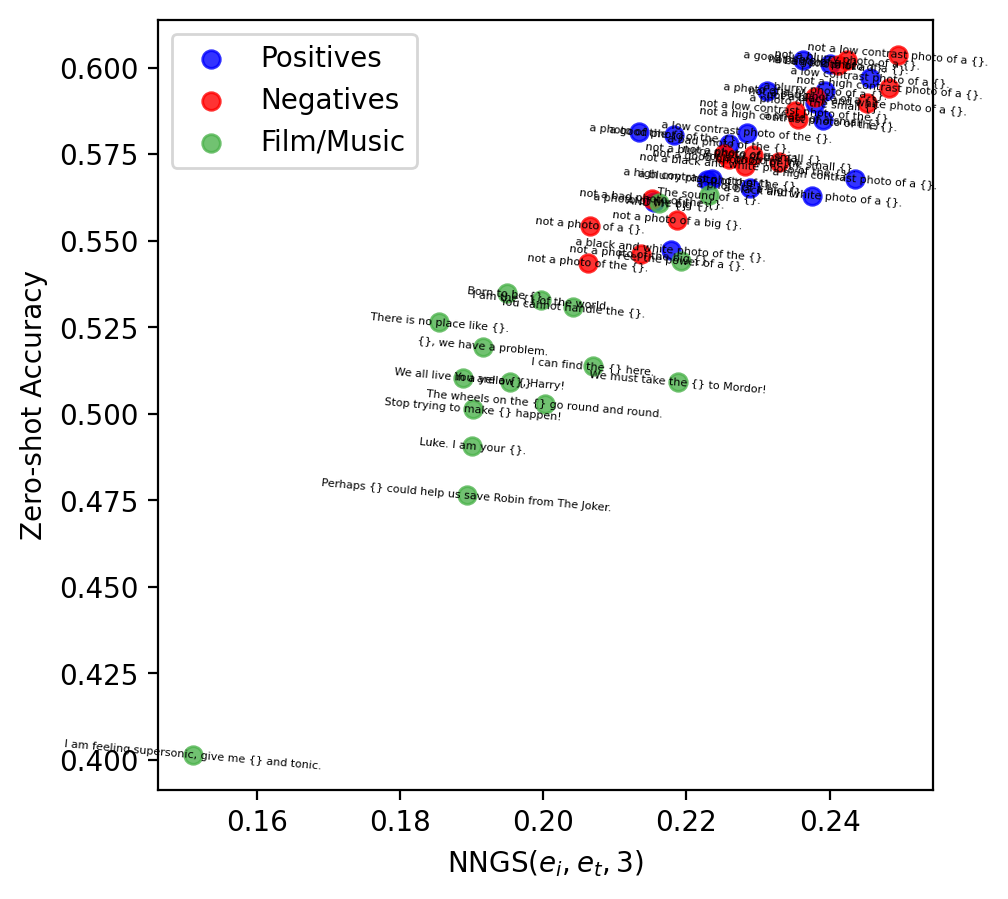

In [23]:
plt.figure(figsize=(5,5))
jdist=np.array(jdist)
acc=np.array(acc)
labels = ['Positives', 'Negatives', 'Film/Music']
colormap = [(0,0,1,1), (1,0,0,1), (0.3,.7,0.3,1)]
colors = [colormap[0]]*len(templates) + [colormap[1]] * len(templates_neg) + [colormap[2]] * len(templates_movies)

plt.scatter(jdist[:len(templates)], acc[:len(templates)], s=40, alpha=0.8, c=colormap[0], label=labels[0])
plt.scatter(jdist[len(templates):len(templates)+len(templates_neg)], acc[len(templates):len(templates)+len(templates_neg)], s=40, alpha=0.8, c=colormap[1], label=labels[1])
plt.scatter(jdist[len(templates)+len(templates_neg):], acc[len(templates)+len(templates_neg):], s=40, alpha=0.8, c=colormap[2], label=labels[2])

for i in range(len(templates_)):
    plt.text(jdist[i], acc[i], templates_[i], fontsize=4, ha='center', va='center', rotation=-5)
    #plt.text(jdist[i], acc[i]-0.01, ks[i], fontsize=8, ha='center', va='top')
# for i in range(n_new):
#     plt.arrow(x=jdist[i], y=acc[i], dx=jdist[n_new+i]-jdist[i], dy=acc[n_new+i]-acc[i],
#               length_includes_head=True, width=0.0002, head_width=0.002, head_length=0.003,
#               alpha=0.5)

plt.xlabel(f'NNGS$(e_i,e_t,{k})$')
plt.ylabel('Zero-shot Accuracy')
plt.savefig('zeroshot_sg_dirty_imagenet.pdf', bbox_inches='tight')
plt.legend()
plt.show()